# **Pygamma-agreement : benchmarking**

This notebook is a report of the various benchmarkings functions that were used for the library's documentation. The goal is mainly to show how the graphs, empirical results and comparisons included in the documentation were obtained.

| ⚠️   |  This notebook uses additional libraries not included in `pygamma-agreement`. Please run `pip install matplotlib tqdm`. |
|-----|----------------------------------------------------------------------------------|


## **1. Speed gains of fast-gamma**

In [1]:
import random

import pygamma_agreement as pa
import matplotlib.pyplot as plt
from typing import Iterable
import numpy as np
import logging
from time import time
from tqdm import tqdm
from time import thread_time_ns

In [6]:
np.random.seed(4775)

def random_continuum(nb_annotators: int, avg_nb_annotations: int) -> pa.Continuum:
    sampler = pa.StatisticalContinuumSampler()
    sampler.init_sampling_custom(annotators=['Ref'],
                                 avg_num_units_per_annotator=avg_nb_annotations, std_num_units_per_annotator=0,
                                 avg_duration=5, std_duration=2,
                                 avg_gap=3, std_gap=2,
                                 categories=np.array([str(i) for i in range(4)]))
    reference = sampler.sample_from_continuum
    cst = pa.CorpusShufflingTool(0.3, reference)
    continuum = cst.corpus_shuffle(nb_annotators, shift=True, cat_shuffle=True)
    
    return continuum



def benchmark_gamma_time(nb_annotators: int, iter_nb_annot: Iterable[int]) -> float:
    times_gamma = []
    times_fast = []
    nb_annot = []
    error = []
    for nb_annotations in tqdm(iter_nb_annot):
        continuum = random_continuum(nb_annotators, nb_annotations)

        dissim = pa.CombinedCategoricalDissimilarity(alpha=3, beta=1, delta_empty=1)

        # same seed is necessary for both algorithms to ensure the same samples are used.
        seed = np.random.randint(0, 10000)
        
        # Gamma
        np.random.seed(seed)
        bp = time()
        gamma = continuum.compute_gamma(dissim, fast=False).gamma
        times_gamma.append(time() - bp)

        # Fast-Gamma
        np.random.seed(seed)
        bp = time()
        fast_gamma = continuum.compute_gamma(dissim, fast=True).gamma
        times_fast.append(time() - bp)
        
        error.append(abs(gamma - fast_gamma))
        nb_annot.append(nb_annotations)

    # Figure
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.set_xlabel('average number of annotations per annotator')
    ax.set_ylabel('Time to compute gamma (seconds)')
    ax.plot(nb_annot, times_gamma, label="Gamma, fast disabled", color="blue", marker="o")
    ax.plot(nb_annot, times_fast, label="Gamma, fast enabled", color="green", marker="o")
    plt.legend(loc='upper left', frameon=False)
    plt.show()
    return float(np.mean(error))

### **1.1. 2 annotators**

* Average look of a  random continuum used for this benchmarking :

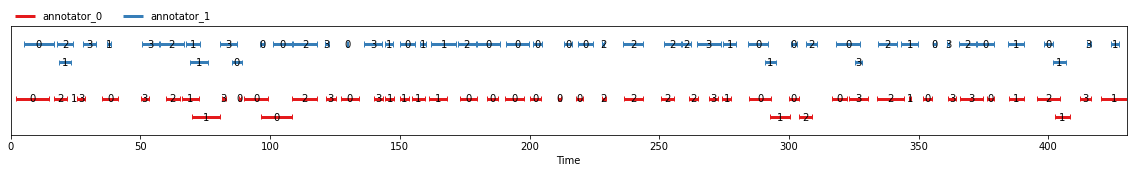

In [7]:
pa.show_continuum(random_continuum(2, 50))

100%|██████████| 17/17 [32:44<00:00, 115.55s/it]


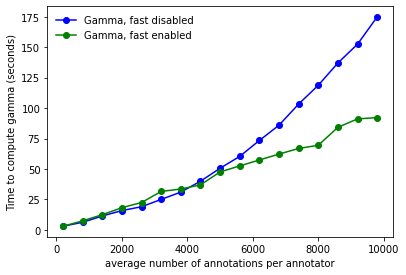

Average error of fast_gamma : 1.325735400740037e-06


In [2]:
logging.getLogger().disabled = True
print(f"Average error of fast_gamma : {benchmark_gamma_time(2, range(200, 10000, 600))}")

We can see here that with **2 annotators**, the gain of speed of soft-gamma is not significant enough when each annotator has on **average less than $\simeq 5000$ annotations**.
The algorithm does, in fact, **detects this beforehand and uses the normal gamma algorithm**. Otherwise, the fast-gamma gives significant speed gains with a high number of annotations per annotator.  
Precision is still more than satisfactory with fast-gamma on the realistic-looking 

### **1.2. 3 annotators**

* Average look of a  random continuum used for this benchmarking :

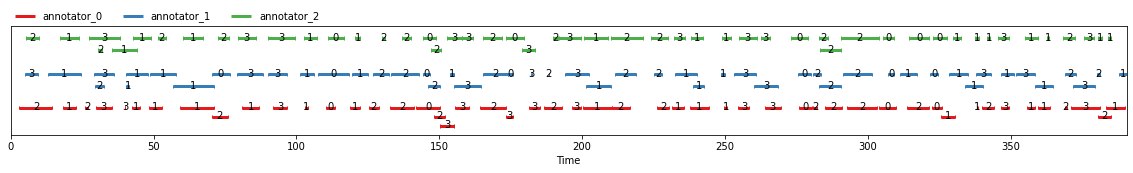

In [9]:
pa.show_continuum(random_continuum(3, 50))

100%|██████████| 10/10 [34:23<00:00, 206.36s/it]


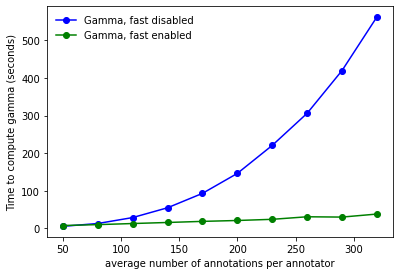

Average error of fast_gamma : 0.0005053960396738111


In [2]:
# 3 annotators:
logging.getLogger().disabled = True
print(f"Average error of fast_gamma : {benchmark_gamma_time(3, range(50, 325, 30))}")

Although the precision is a bit less satisfying than with 2 annotators, **the gain of speed is much more significant**. While it takes a certain number of annotations for fast-gamma to be faster with 2 annotators, it becomes **instantly indispensable when the number of annotators increase**.
Moreover, the precision of fast-gamma is still excellent. 

## **2. precision of fast-gamma**

In this section, we'll try to establish empirically that the precision of fast-gamma is more than reliable in real scenarios.

In [10]:
def precision(n: int):
    overlapping = []
    error = []
    fast_gamma_results = []
    for p in tqdm([i / n for i in range(-n, n+1)]):
        duration = 5

        sampler = pa.StatisticalContinuumSampler()
        sampler.init_sampling_custom(annotators=['Ref'],
                                     avg_num_units_per_annotator=30, std_num_units_per_annotator=0,
                                     avg_duration=duration, std_duration=1,
                                     avg_gap=duration * p, std_gap=1,
                                     categories=np.array([str(i) for i in range(4)]))
        reference = sampler.sample_from_continuum
        cst = pa.CorpusShufflingTool(0.3, reference)
        continuum = cst.corpus_shuffle(["martin", "martino", "martine"], shift=True, cat_shuffle=True)

        dissim = pa.CombinedCategoricalDissimilarity(alpha=3, beta=1, delta_empty=1)
        
        seed = np.random.randint(0, 10000)
        # Gamma
        np.random.seed(seed)
        gamma = continuum.compute_gamma(dissim, fast=False, sampler=pa.ShuffleContinuumSampler()).gamma

        # Fast-Gamma
        np.random.seed(seed)
        fast_gamma = continuum.compute_gamma(dissim, fast=True, sampler=pa.ShuffleContinuumSampler())
        
        error.append(abs(gamma - fast_gamma.gamma))
        overlapping.append(p)
        
        fast_gamma_results.append(fast_gamma)
        
    # Figure
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Overlapping of units')
    ax.set_xlim([overlapping[0] * 1.1, overlapping[-1] * 1.1])
    ax.set_ylabel('Error rate')
    ax.plot(overlapping, error, color="blue", marker="o")
    plt.show()
    
    return fast_gamma_results, error
    

100%|██████████| 21/21 [03:14<00:00,  9.26s/it]


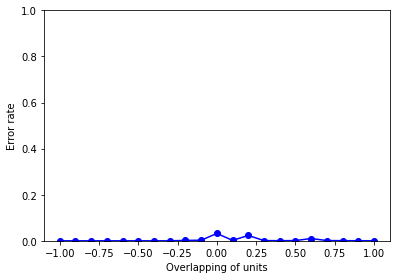

In [11]:
np.random.seed(4775)
logging.getLogger().disabled = True
fast_gamma_results, error = precision(10)

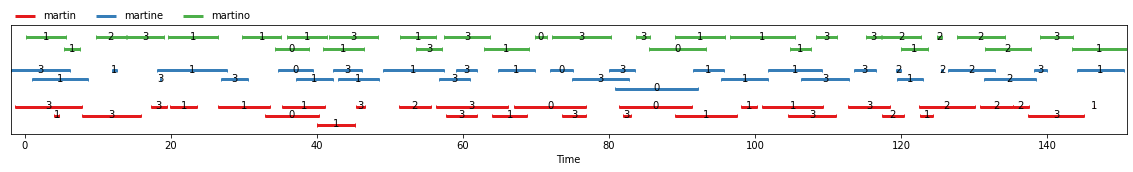

In [17]:
most_error_cont = fast_gamma_results[np.argmax(error)].best_alignment.continuum
pa.show_continuum(most_error_cont)

## **3. optimal window size for fast-gamma**

As explained in the "performance" section of the documentation, one can find an window size for which fast-gamma has an optimal time of computation.
The following function aims to show that finding it only requires **searching the minimum of a certain function.**

In [2]:
def fastgamma_windowing(num_units: int, nb_annotators: int, windows: Iterable[int]):
    # We use the statistical continuum sampler to create a reference for the cst.
    nb_annotators = 3
    num_units = 500

    n = num_units
    p = nb_annotators

    sampler = pa.StatisticalContinuumSampler()
    sampler.init_sampling_custom(annotators=['Ref'],
                                 avg_num_units_per_annotator=num_units, std_num_units_per_annotator=0,
                                 avg_duration=100, std_duration=25,
                                 avg_gap=0, std_gap=25,
                                 categories=np.array([str(i) for i in range(4)]))
    continuum = sampler.sample_from_continuum
    cst = pa.CorpusShufflingTool(0.3, continuum)
    cont_cst = cst.corpus_shuffle([f"annotator_{i}" for i in range(nb_annotators)], shift=True, cat_shuffle=True, )

    dissim = pa.CombinedCategoricalDissimilarity(alpha=3, beta=1, delta_empty=1.0)    
    
    # s = "additionnal" window size. As it is very hard to estimate, we'll suppose that it is strictly equal to
    # the one of the first window of size 1. Trial and error has shown that it is sufficiently precise for homogeneous
    # continua.
    smallest_window, _ = cont_cst.get_first_window(dissim, 1)
    s = smallest_window.max_num_annotations_per_annotator - 1

    # BENCHMARKING
    times = []
    window_sizes = []
    for window_size in tqdm(range(3, 100, 3)):
        n_pts = 3
        times_ws = []
        disorders = []
        unitary_alignments = []
        copy = cont_cst.copy()
        bp = thread_time_ns()
        while copy:
            window, x_limit = copy.get_first_window(dissim, window_size)
            best_alignment = window.get_best_alignment(dissim)
            for chosen in best_alignment.take_until_limit(x_limit):
                unitary_alignments.append(chosen)
                disorders.append(chosen.disorder)
                for annotator, unit in chosen.n_tuple:
                    if unit is not None:
                        copy.remove(annotator, unit)
        times.append((thread_time_ns() - bp))
        window_sizes.append(window_size)

    times = np.array(times)
    times *= 1000000
    window_sizes = np.array(window_sizes)

    fig: plt.Figure
    ax: plt.Axes
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.set_xlabel('Window size')
    ax.set_ylabel('Time to compute (s)')
    
    numba_factor = 1 / 20 # This factor is an estimation and was found by trial and error.

    def C(w): # Complexity of fast-gamma, depending on the window size.
        return ((n - w) * p / 2 + 2 * p + (w + s * p) * p  # getting first window
                + (n - w) * p / 2 + numba_factor * (w + s) ** p  # getting best alignment ( times numba factor)
                + (w + s) * p * np.log2((w + s) * p) + w * p  # getting the w leftmost alignments & adding them
                ) * (n / w) # + log2()

    # adding the log factorial corresponds to the emptying-the-continuum-unit-by-unit time.
    logfactorials = np.log2(window_sizes)
    for i in range(1, len(logfactorials)):
        logfactorials[i] += logfactorials[i - 1]

    interpol = C(window_sizes) + p * logfactorials

    # Rescaling interpolation function (doesn't affect the emplacement of the optimal window)
    interpol *= np.mean([times[i] / C(window_sizes[i]) for i in range(len(window_sizes))])

    ax.plot(window_sizes, times, color='green', label='Fast-gamma real time')
    ax.plot(window_sizes, interpol, color='gray', linestyle='dotted', label='Fast-gamma estimation (re-scaled)')

    ax.legend(loc='upper center')
    plt.show()

100%|██████████| 33/33 [01:01<00:00,  1.85s/it]


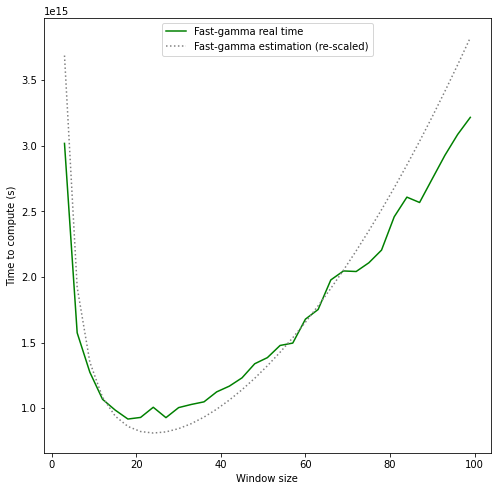

In [3]:
fastgamma_windowing(500, 2, range(3, 200, 20))

100%|██████████| 33/33 [01:00<00:00,  1.83s/it]


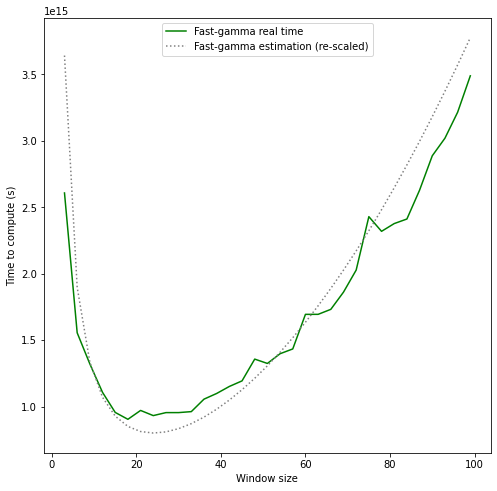

In [4]:
fastgamma_windowing(100, 3, range(3, 50, 5))

The $C$ function being :  
    $C(w, N, n, p) = N \times (\frac{n}{w} \times (\lambda \times (w + s)^p + D(n, p, w, s))$  
the complexity of fast-gamma, as explained in the *Performances* section.  
What these graphs show is that sampling this function is more than reliable to estimate the theoretical optimal window size 
for the fast-gamma algorithm.

## **4. Results comparaison : soft-gamma and gamma**

This part serves the purpose of showing the 

In [14]:
 def soft_gamma_compare(nb_annotators: int, nb_annotations: int, range_magnitudes: Iterable[float], shift: bool, split: bool):
    gammas = []
    gammas_soft = []
    gammas_weighted = []
    mean_weights = []
    magnitudes = []

    sampler = pa.StatisticalContinuumSampler()
    sampler.init_sampling_custom(annotators=['Ref'],
                                 avg_num_units_per_annotator=nb_annotations, std_num_units_per_annotator=0,
                                 avg_duration=5, std_duration=2,
                                 avg_gap=3, std_gap=2,
                                 categories=np.array([str(i) for i in range(4)]))
    reference = sampler.sample_from_continuum
    cst = pa.CorpusShufflingTool(0, reference)

    last_alignment: pa.Alignment
    seed = np.random.randint(0, 1000)

    for magnitude in tqdm(range_magnitudes):
        np.random.seed(seed)
        cst.magnitude = magnitude
        continuum = cst.corpus_shuffle(nb_annotators, shift=shift, split=split)
        dissim = pa.CombinedCategoricalDissimilarity(alpha=0.75, beta=0.25, delta_empty=1)

        np.random.seed(seed)
        gamma_res = continuum.compute_gamma(dissim, soft=False)
        gammas.append(gamma_res.gamma)

        np.random.seed(seed)
        gamma_res = continuum.compute_gamma(dissim, soft=True)
        gammas_soft.append(gamma_res.gamma)

        last_alignment = gamma_res.best_alignment

        magnitudes.append(magnitude)

        # Gamma

    # Figure
    fig: plt.Figure
    ax: plt.Axes
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.set_xlabel('Magnitude')
    ax.set_xlim(0, 1)
    ax.set_ylabel('Gamma')
    ax.set_ylim(0, 1)
    ax.plot(magnitudes, gammas, label="Gamma", color='red')
    ax.plot(magnitudes, gammas_soft, label="Soft-Gamma",  color='green')
    ax.legend(loc='lower left')

100%|██████████| 21/21 [04:04<00:00, 11.64s/it]


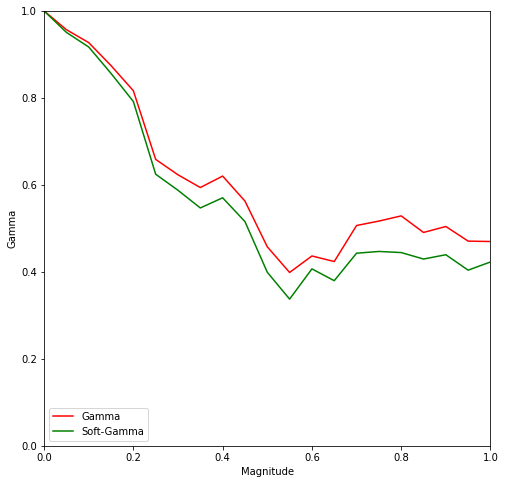

In [15]:
n = 20
soft_gamma_compare(3, 50, [i / n for i in range(n+1)], shift=True, split=False)

100%|██████████| 21/21 [27:20<00:00, 78.14s/it] 


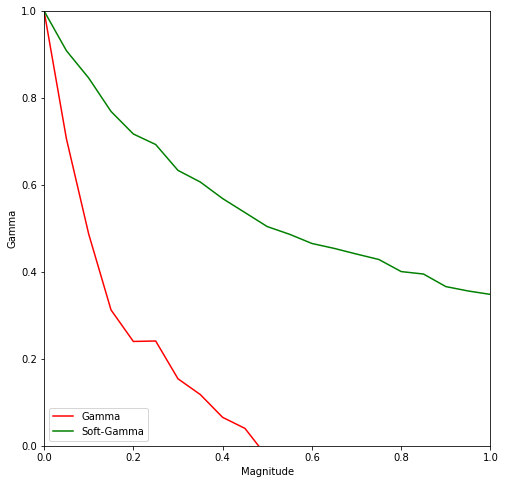

In [16]:
soft_gamma_compare(3, 50, [i / n for i in range(n+1)], shift=False, split=True)